In [1]:
import pickle as pkl
import numpy as np
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import json
ROOT = '/home/kevinkuo/meta-fedex'
os.chdir(ROOT)

Change ROOT to the project directory. 

Run all of the cells in order to generate the plots.

In [2]:
datasets = [
    "CIFAR10",
    "FEMNIST",
    "StackOverflow",
    "Reddit"
]

# Includes 36 for StackOverflow and 100 for Reddit (for ~1% of clients)
NC_dict = {
    "CIFAR10":       [1,3,9,27,100],
    "FEMNIST":       [1,3,9,27,81,360],
    "StackOverflow": [1,3,9,27,36,81,243,729,3678],
    "Reddit":        [1,3,9,27,81,100,243,729,2187,10000],
}

NC_dict_pow = {
    "CIFAR10":       [1,3,9,27,100],
    "FEMNIST":       [1,3,9,27,81,360],
    "StackOverflow": [1,3,9,27,81,243,729,3678],
    "Reddit":        [1,3,9,27,81,243,729,2187,10000],
}

nc_dict = {
    "CIFAR10":       1,
    "FEMNIST":       3,
    "StackOverflow": 36,
    "Reddit":        100,
}

def get_proxy(d):
    d = d.lower()
    if "cifar10" in d:
        proxy_d = 'femnist'
    elif "femnist" in d:
        proxy_d = 'cifar10'
    elif "stackoverflow" in d:
        proxy_d = 'reddit'
    elif "reddit" in d:
        proxy_d = 'stackoverflow'
    return proxy_d

def nc_to_str(nc, NUM_CLIENTS):
    if nc == NUM_CLIENTS[-1]:
        return f"100%"
    elif nc / NUM_CLIENTS[-1] > 0.1:
        return f"{100*nc/NUM_CLIENTS[-1]:.2g}% ({nc})"
    else:
        return f"{100*nc/NUM_CLIENTS[-1]:.1g}% ({nc})"


def get_title(d):
    for title in datasets:
        if d in title.lower():
            return title
    return title

In [3]:
# Load dataset sizes: we store the number of images / text sequences for each client.
# We also need to get the number of tokens on each client for the NWP tasks.
sizes_dicts = {}
sizes = {}
for ds in datasets:
    with open(f"data/{ds.lower()}/eval_clients.json") as f:
        sizes_dict = json.load(f)
        sizes_dicts[ds] = sizes_dict
        sizes[ds] = np.array(list(sizes_dict.values()))

# For Reddit and StackOverflow, we replace this with the number of *tokens* on each client, since:
# a) The training objective is weighted by clients' token count, so we match this match this in evaluation.
# b) Because data is repartitioned at the sentence level for data heterogeneity,
#    the client 'sizes' used by the weighted evaluation change after repartitioning.

### COMMENT OUT IF NOT RUNNING TEXT DATASETS
# Populate tok_sizes with the num. of tokens in each example
toks_per_seq = {}
for dataset in ['StackOverflow', 'Reddit']:
    ex_tok_counts = []
    for i, (client_id, client_size) in tqdm(enumerate(sizes_dicts[dataset].items())):
        task = f"./data/{dataset.lower()}/cache/{client_id}.pt"
        X = torch.load(task)['X']
        non_pad_idx = X[:, 1:] != 50256 
        count = non_pad_idx.sum(axis=1).cpu().numpy()
        ex_tok_counts.append(count)
        assert client_size == len(count)
    ex_tok_counts = np.concatenate(ex_tok_counts)
    toks_per_seq[dataset] = ex_tok_counts

# Transform this into the number of tokens per client after repartitioning
toks_per_client = {}
for ds in datasets:
    for data_p in [0, 0.5, 1]:
        if data_p == 0:
            eval_perm = np.arange(sizes[ds].sum())
        else:
            eval_perm = np.load(f"data/{ds.lower()}/eval_perm_p={data_p}.npy")
        
        if ds == "CIFAR10" or ds == "FEMNIST":
            toks_per_seq_shuffled = np.ones(len(eval_perm))
        else:
            toks_per_seq_shuffled = toks_per_seq[ds][eval_perm]
            
        toks_per_client_shuffled = []
        curr = 0
        for num_seq in sizes[ds]:
            toks_per_client_shuffled.append(toks_per_seq_shuffled[curr:curr+num_seq].sum())
            curr += num_seq
        toks_per_client[ds, data_p] = np.array(toks_per_client_shuffled)

sizes = toks_per_client

3678it [00:01, 2664.40it/s]
10000it [00:02, 3592.30it/s]


Training uses either a weighted or uniform loss across clients. We analyze results from uniform loss runs whenever differential privacy is involved, as a uniform loss bounds individual client sensitivity. However, in all other experiments, we use the weighted loss runs.

In [4]:
def load_evals(eval_dir):
    eval_dict = {}
    for run in os.listdir(eval_dir):
        for round_fn in os.listdir(f"{eval_dir}/{run}"): # RX.pkl
            round = int(round_fn.split('R')[1][:-4])
            if round_fn.startswith("R"):
                p = 0
            elif round_fn.startswith('P'):
                p = float(round_fn.split('_')[0][1:])
            else:
                raise Exception()
            
            with open(f"{eval_dir}/{run}/{round_fn}", "rb") as f:
                evals = pkl.load(f)

            eval_dict[run, round, float(p)] = evals['GlobalError'] / evals['num_train']
    return eval_dict

eval_dicts = {}
for ds in datasets:
    eval_dicts[ds] = load_evals(f"runs_weighted/runs_simple/runs_{ds.lower()}/eval")

unif_eval_dicts = {}
for ds in datasets:
    unif_eval_dicts[ds] = load_evals(f"runs_unif/runs_simple/runs_{ds.lower()}/eval")

0. Simulate RS results using logged fedtrain_simple.py runs

In [5]:
def run_rs(client_sizes, runs, eval_dict, nc, NC, N, R=405, data_p=0, dp_eps=None, sys_bias=0):
    # T = np.random.choice(runs, N, replace=False)
    T = runs
    sub_evals = []
    for i, run in enumerate(T):
        client_evals = eval_dict[run, R, data_p]
        if nc == len(client_evals):
            sample_idx = np.arange(nc)
        else:
            client_idx = np.arange(len(client_evals))
            if sys_bias == 0:
                sample_idx = np.random.choice(client_idx, nc, replace=False)
            else:
                biased_prob = (1.0001-client_evals)**sys_bias
                biased_prob /= biased_prob.sum()
                sample_idx = np.random.choice(client_idx, nc, replace=False, p=biased_prob)
        if dp_eps is None: # Weighted eval
            sub_eval = (client_evals[sample_idx]*client_sizes[sample_idx]).sum() / client_sizes[sample_idx].sum()
        else: # Uniform eval for DP evaluation, which bounds the eval sensitivity wrt individual clients.
            sub_eval = client_evals[sample_idx].sum() / nc
        sub_evals.append(sub_eval)
    noise = np.random.laplace(scale=N/(nc*dp_eps), size=N) if dp_eps is not None else 0
    noisy_evals = np.clip(np.array(sub_evals)+noise, 0.0, 1.0)
    trace_true = []
    trace_noisy = []
    max_run = T[0]
    for i in range(N):
        noisy_eval = noisy_evals[i]
        client_evals = eval_dict[T[i], R, data_p]
        if dp_eps is None: # weighted
            true_eval = (client_evals*client_sizes).sum() / client_sizes.sum()
        else: # uniform
            true_eval = client_evals.sum() / len(client_evals)
        if len(trace_noisy) == 0 or noisy_eval < trace_noisy[-1]:
            trace_noisy.append(noisy_eval)
            trace_true.append(true_eval)
            max_run = T[i]
        else:
            trace_noisy.append(trace_noisy[-1])
            trace_true.append(trace_true[-1])
    # best = min([eval_dict[run, R, NC, p][0] for run in sample_runs])
    # rand = np.mean([eval_dict[run, R, NC, p] for run in sample_runs])
    return np.arange(1,N+1)*R, np.array(trace_true), np.array(trace_noisy), max_run

In [6]:
np.random.seed(0)
EPS = [None, 0.1, 1, 10, 100]
P = [0, 0.5, 1.0]
trials = 100
rs_results = {k: {} for k in eval_dicts.keys()} # weighted_rs_results
dp_rs_results = {k: {} for k in unif_eval_dicts.keys()} # unif_rs_results

# Runs experiments for subsampling and data / systems heterogeneity.
for ds, eval_dict in list(eval_dicts.items()):
    runs = list(run for run, _, _ in eval_dict.keys())
    trials_runs = [np.random.choice(runs, 16, replace=False) for trial in range(trials)]
    NUM_CLIENTS = NC_dict[ds]
    sub_nc = nc_dict[ds]
    cfg_results = {}
    for nc in NUM_CLIENTS:
        configs = []
        for data_p in P:
            configs.append((nc, data_p, None, 0))

        for sys_bias in [1, 1.5, 3]:
            configs.append((nc, 0, None, sys_bias))
        
        for config in configs:
            cfg_results[config] = []
            nc, data_p, dp_eps, sys_bias = config
            for trial in range(trials):
                client_sizes = sizes[ds,data_p]
                trial_runs = trials_runs[trial]
                cfg_results[config].append(run_rs(
                    client_sizes, trial_runs, eval_dict, nc=nc, N=16, NC=NUM_CLIENTS[-1], R=405, 
                    data_p=data_p, dp_eps=dp_eps, sys_bias=sys_bias))
    rs_results[ds].update(cfg_results)

# Generates RS + DP Evaluation
data_p = 0
sys_bias = 0
for ds, eval_dict in list(unif_eval_dicts.items()):
    runs = list(run for run, _, _ in eval_dict.keys())
    trials_runs = [np.random.choice(runs, 16, replace=False) for trial in range(trials)]
    NUM_CLIENTS = NC_dict[ds]
    cfg_results = {}
    for nc in NUM_CLIENTS:
        for dp_eps in EPS:
            config = (nc, data_p, dp_eps, sys_bias)
            cfg_results[config] = []
            # nc, data_p, dp_eps, sys_bias = config
            for trial in range(trials):
                client_sizes = sizes[ds,data_p]
                cfg_results[config].append(run_rs(
                    client_sizes, trials_runs[trial], eval_dict, N=16, NC=NUM_CLIENTS[-1], R=405, 
                    nc=nc, data_p=data_p, dp_eps=dp_eps, sys_bias=sys_bias))
        dp_rs_results[ds].update(cfg_results)

1. Client Subsampling

In [7]:
def plot_subsampling_trace(ax, results, dataset, N, data_p=0, dp_eps=None, sys_bias=0, label='', color='k'):
    ncs = NC_dict_pow[dataset]
    md = [100*np.median(  np.array([trial[1][N-1] for trial in results[nc,data_p,dp_eps,sys_bias]]), axis=0) for nc in ncs]
    q1 = [100*np.quantile(np.array([trial[1][N-1] for trial in results[nc,data_p,dp_eps,sys_bias]]), q=0.25, axis=0) for nc in ncs]
    q2 = [100*np.quantile(np.array([trial[1][N-1] for trial in results[nc,data_p,dp_eps,sys_bias]]), q=0.75, axis=0) for nc in ncs]
    ax.plot(ncs, md, label=label, marker='o', linestyle='dashed', color=color)
    ax.fill_between(ncs, q1, q2, alpha=0.2, color=color)

def set_subsampling_text(ax, dataset):
    ax.set_xscale('log')
    nc_strs = []
    max_c = NC_dict_pow[dataset][-1]
    for nc in NC_dict_pow[dataset]:
        if nc == max_c:
            nc_strs.append(f"100%\n({nc})")
        elif nc / max_c > 0.1:
            nc_strs.append(f"{100*nc/max_c:.2g}%\n({nc})")
        else:
            nc_strs.append(f"{100*nc/max_c:.1g}%\n({nc})")
    ax.set_xticks(NC_dict_pow[dataset], nc_strs)
    ax.set_title(dataset)

Figure 3: Subsampling

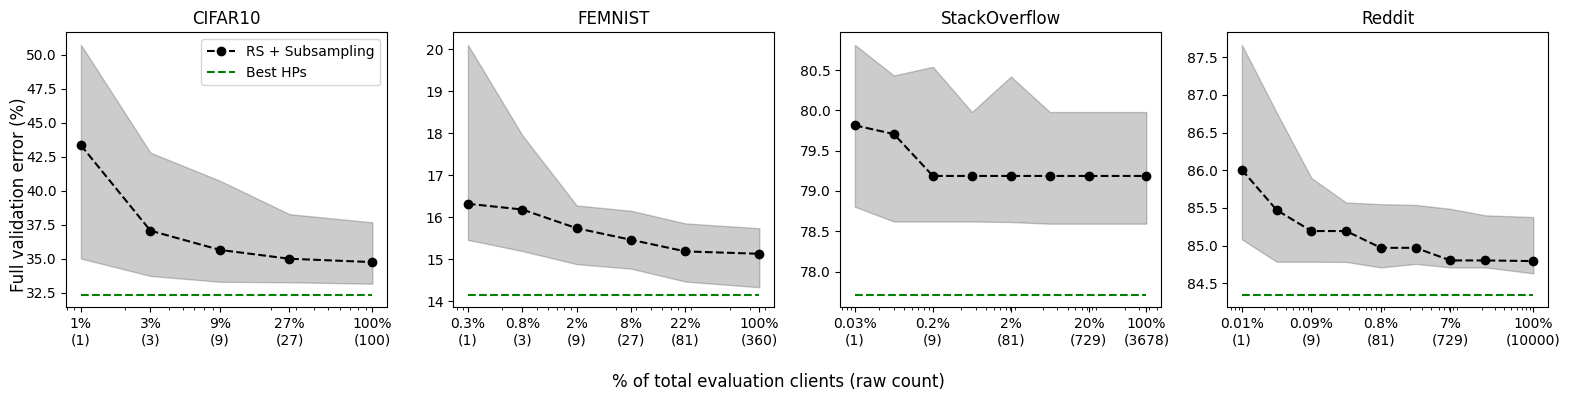

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(16,4))
for i, ds in enumerate(datasets):
    results = rs_results[ds]
    ax = axs[i]
    plot_subsampling_trace(ax, results, ds, N=16, data_p=0, dp_eps=None, sys_bias=0, label='RS + Subsampling')

    # trial[0] / trial[1] are the observed / true error rates.
    NUM_CLIENTS = NC_dict[ds]
    best = [trial[1] for trial in results[NUM_CLIENTS[-1],0,None,0]]
    # We plot the best over all trials in green.
    ax.plot([1, NUM_CLIENTS[-1]], [100*np.min(best, axis=0)[-1]]*2, linestyle='dashed', label='Best HPs', color='green')

    set_subsampling_text(ax, ds)

axs[0].legend(title="")
axs[2].set_xticks([1,9,81,729,3678])
axs[3].set_xticks([1,9,81,729,10000])
fig.supxlabel("% of total evaluation clients (raw count)")
fig.supylabel("Full validation error (%)")
plt.tight_layout()
# plt.savefig("figures/SUB_RATE.pdf")
plt.show()

Figure 4: Subsampling + Budget

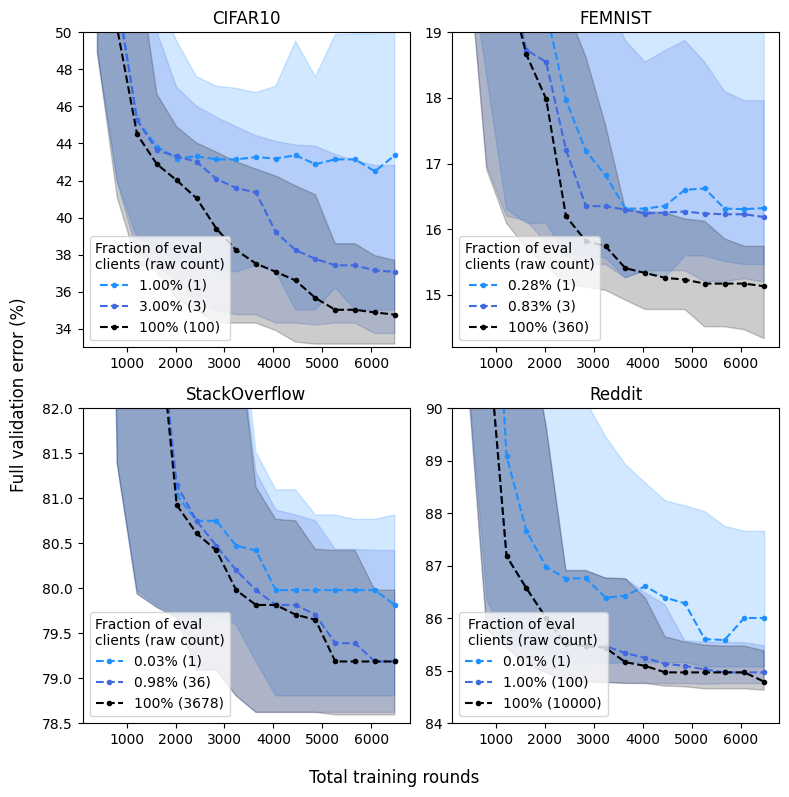

In [9]:
c = ["k", "royalblue", "dodgerblue"]
def plot_budget_trace(ax, budgets, traces, label, linestyle=None, color=None):
    md = 100*np.median(traces, axis=0)
    q1 = 100*np.quantile(traces, q=0.25, axis=0)
    q2 = 100*np.quantile(traces, q=0.75, axis=0)
    ax.plot(budgets, md, label=f"{label}", linestyle=linestyle, marker='o', markersize=3, c=color)
    ax.fill_between(budgets, q1, q2, alpha=0.2, color=color)

X = 405*np.arange(1,17)
fig, axs = plt.subplots(2,2,figsize=(8,8))
# fig, axs = plt.subplots(1,4,figsize=(16,4))

for i, ds in enumerate(datasets):
    ax = axs[i//2][i%2]
    # ax = axs[i]

    NC = NC_dict[ds]
    nc = nc_dict[ds]
    plot_budget_trace(ax, X, [trial[1] for trial in rs_results[ds][1, 0, None, 0]], label=f"{100.0/NC[-1]:.2f}% (1)", linestyle='dashed', color=c[2])
    if nc == 1:
        plot_budget_trace(ax, X, [trial[1] for trial in rs_results[ds][3, 0, None, 0]], label=f"{100*3/NC[-1]:.2f}% ({3})", linestyle='dashed', color=c[1])
    elif nc == 81:
        plot_budget_trace(ax, X, [trial[1] for trial in rs_results[ds][27, 0, None, 0]], label=f"{100*27/NC[-1]:.2f}% ({27})", linestyle='dashed', color=c[1])
    else:
        plot_budget_trace(ax, X, [trial[1] for trial in rs_results[ds][nc, 0, None, 0]], label=f"{100*nc/NC[-1]:.2f}% ({nc})", linestyle='dashed', color=c[1])
    plot_budget_trace(ax, X, [trial[1] for trial in rs_results[ds][NC[-1], 0, None, 0]], label=f"100% ({NC[-1]})", linestyle='dashed', color=c[0])

    ax.set_title(ds)
    
    if i == 0:
        ax.set_ylim(33, 50)
        # ax.set_xticks([])
    elif i == 1:
        ax.set_ylim(14.2, 19)
        # ax.set_xticks([])
    elif i == 2:
        ax.set_ylim(78.5,82)
    elif i == 3:
        ax.set_ylim(84,90)
    ax.legend(title="Fraction of eval\nclients (raw count)", loc='lower left')

fig.supxlabel("Total training rounds")
fig.supylabel("Full validation error (%)")
plt.tight_layout()
# plt.savefig('figures/SUB_BUDGET.pdf')
plt.show()

Figure 5: Data Heterogeneity

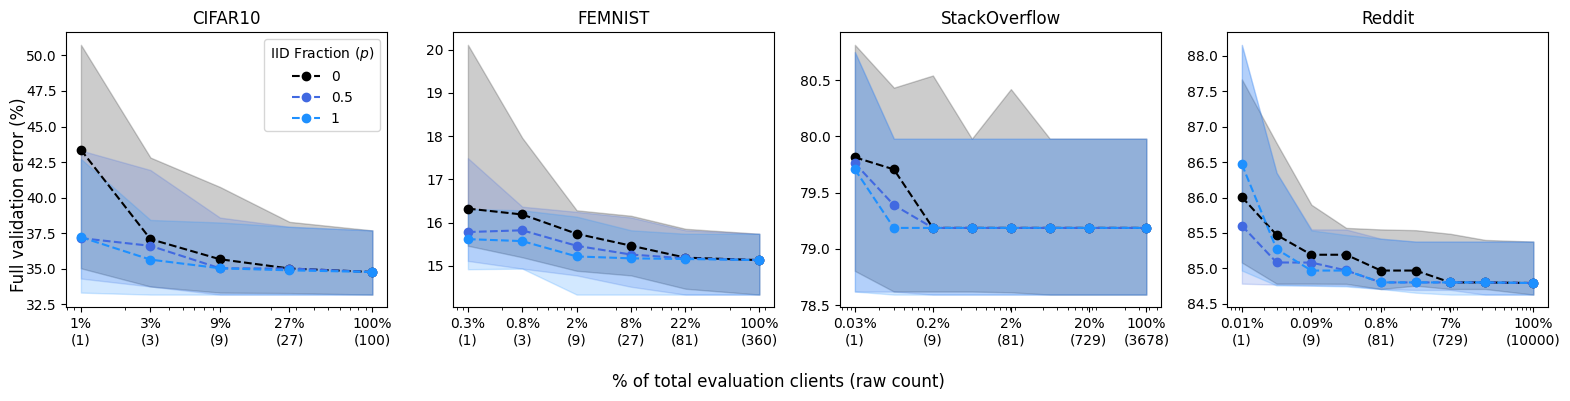

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16,4))
c = ["k", "royalblue", "dodgerblue"]
for i, ds in enumerate(datasets):
    ax = axs[i]
    results = rs_results[ds]
    for j, data_p in enumerate([0, 0.5, 1]):
        plot_subsampling_trace(ax, results, ds, N=16, data_p=data_p, dp_eps=None, sys_bias=0, label=f"{data_p}", color=c[j])
    
    ax.set_xscale('log')
    set_subsampling_text(ax, ds)
    

axs[0].legend(title="IID Fraction $(p)$")
axs[2].set_xticks([1,9,81,729,3678])
axs[3].set_xticks([1,9,81,729,10000])
fig.supxlabel("% of total evaluation clients (raw count)")
fig.supylabel("Full validation error (%)")
plt.tight_layout()
# plt.savefig("figures/NIID.pdf")
plt.show()

Figure 6: Systems Heterogeneity

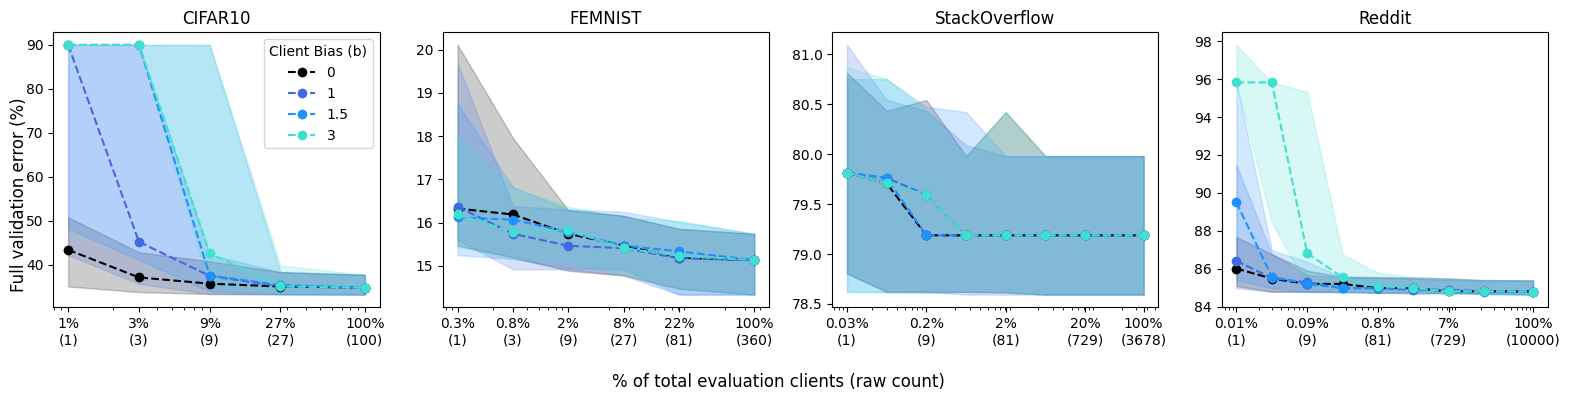

<Figure size 640x480 with 0 Axes>

In [11]:
c = ["k", "royalblue", "dodgerblue", "turquoise"]
fig, axs = plt.subplots(1, 4, figsize=(16,4))
for i, ds in enumerate(datasets):
    ax = axs[i]
    results = rs_results[ds]
    for j, b in enumerate([0, 1, 1.5, 3]):
        plot_subsampling_trace(ax, results, ds, N=16, data_p=0, dp_eps=None, sys_bias=b, label=str(b), color=c[j])

    set_subsampling_text(ax, ds)
    

axs[0].legend(title="Client Bias (b)")
axs[2].set_xticks([1,9,81,729,3678])
axs[3].set_xticks([1,9,81,729,10000])
fig.supxlabel("% of total evaluation clients (raw count)")
fig.supylabel("Full validation error (%)")
plt.tight_layout()
# plt.savefig("figures/SYS.pdf")
plt.show()

plt.tight_layout()
plt.show()

Figure 7: Configuration errors

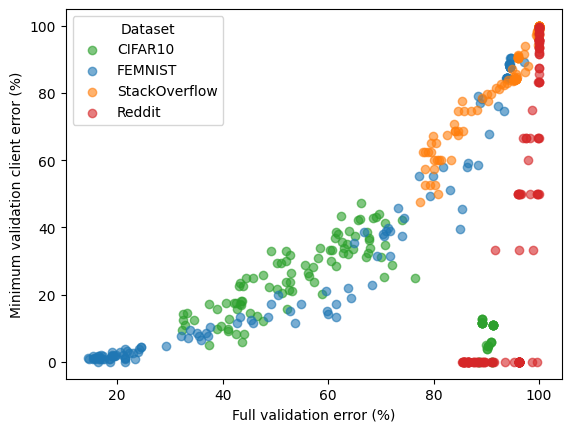

In [12]:
c = ['tab:green', 'tab:blue', 'tab:orange', 'tab:red']
i = 0
for ds in datasets:
    means, mins = [], []
    for k, v in eval_dicts[ds].items():
        if k[1] == 405 and k[2] == 0.0:
            means.append(v.mean()*100)
            mins.append(v.min()*100)
    plt.scatter(means[:127], mins[:127], label=ds, alpha=0.6, color=c[i])
    # ax.set_title(d)
    i+=1
plt.xlabel('Full validation error (%)')
plt.ylabel('Minimum validation client error (%)')
plt.legend(title='Dataset')
# plt.savefig('figures/SYS_SCATTER.pdf')

Figure 8: Privacy

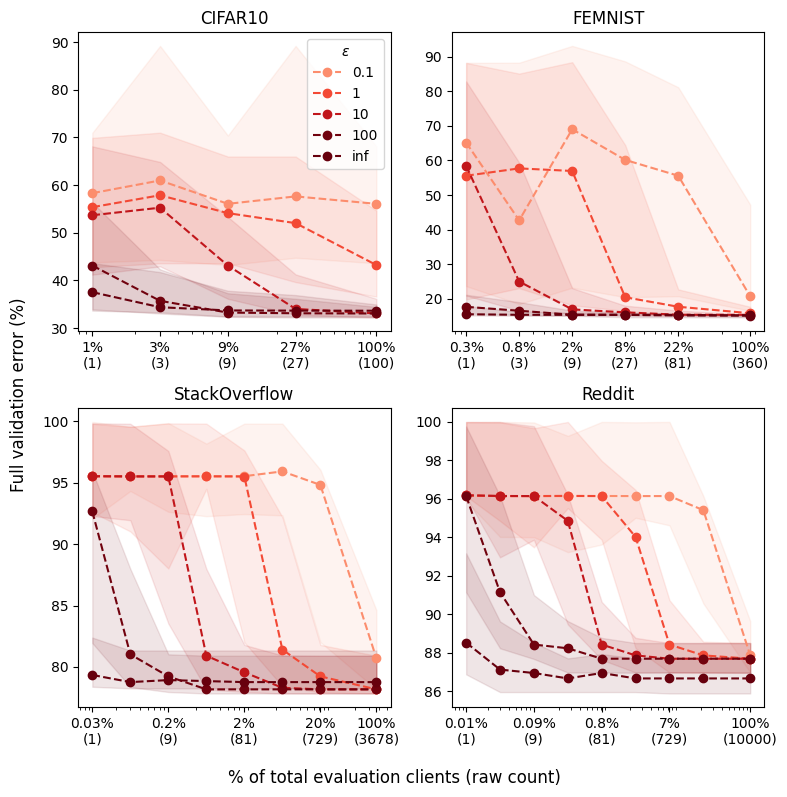

<Figure size 640x480 with 0 Axes>

In [35]:
c = plt.get_cmap('Reds')
alg = "RS (N=16)"
# fig, axs = plt.subplots(1,4, figsize=(16,4))
fig, axs = plt.subplots(2,2, figsize=(8,8))
# for i, d in enumerate(datasets):
for i, ds in enumerate(['CIFAR10', 'FEMNIST', 'StackOverflow', 'Reddit']):
    # ax = axs[i]
    ax = axs[i//2][i%2]
    results = dp_rs_results[ds]
    for j, dp_eps in enumerate(EPS[1:] + [None]):
        color = c(100 + j*50)
        plot_subsampling_trace(ax, results, ds, N=16, data_p=0, dp_eps=dp_eps, sys_bias=0, label=str(dp_eps) if dp_eps is not None else "inf", color=color)

    set_subsampling_text(ax, ds)
    

    if i == 0:
        ax.legend(title="$\epsilon$", loc='upper right')
    if i == 2:
        ax.set_xticks([1,9,81,729,3678])
    if i == 3:
        ax.set_xticks([1,9,81,729,10000])
fig.supxlabel("% of total evaluation clients (raw count)")
fig.supylabel("Full validation error (%)")
plt.tight_layout()
# plt.savefig("figures/DP.pdf")
plt.show()

plt.tight_layout()
plt.show()

Simulate HB Results

In [14]:
def run_hb(client_sizes, runs, eval_dict, nc, NC, eta=3, R=81, data_p=0, dp_eps=None, sys_bias=0):
    s_max = int(np.log(R) / np.log(eta))
    B = (s_max + 1)*R
    trace_bud = []
    trace_noisy = [] # stores best noisy eval
    trace_run = []    # stores corresponding run
    trace_true = [] # true performance
    budget_used = 0
    max_rd = 0
    for s in range(s_max, -1, -1):
    # for s in range(0, s_max+1):
        n = int(np.ceil((B/R)*(eta**s)/(s+1)))
        if n > len(runs):
            raise Exception()
        r = R*eta**(-s)
        T = np.random.choice(runs, n, replace=False) # stores run names
        # T = np.arange(n+1)
        for i in range(s+1):
            n_i = int(n*eta**(-i))
            r_i = int(r*(eta**i))
            r_im = int(r*(eta**(i-1))) if i >= 0 else 0
            rd = int(5*r_i) # Without eval at round 5, will use eval at round 0.
            # print(f"bracket {s} rung {i} : configs {n_i} budget {r_i}")
            noisy_evals = []
            for run in T:
                budget_used += (r_i - r_im)
                client_evals = eval_dict[run, rd, data_p]
                if sys_bias == 0:
                    sample_idx = np.random.choice(len(client_evals), nc, replace=False)
                else:
                    biased_prob = (1.0001-client_evals)**sys_bias
                    biased_prob /= biased_prob.sum()
                    sample_idx = np.random.choice(len(client_evals), nc, replace=False, p=biased_prob)
                sub_eval = (client_evals[sample_idx]*client_sizes[sample_idx]).sum() / client_sizes[sample_idx].sum()
                # 2*T*k_t / dp_eps*|S|
                # |S| = nc (num clients)
                # k_t = len(T) // eta, last eval is 10 configs from all 5 brackets
                # T = 11 elim rounds
                if i == s:
                    noise = np.random.laplace(scale=(2*11*(10))/(nc*dp_eps)) if dp_eps is not None else 0
                else:
                    noise = np.random.laplace(scale=(2*11*(n_i//eta))/(nc*dp_eps)) if dp_eps is not None else 0
                
                sub_eval = np.clip(sub_eval+noise, 0.0, 1.0)
                noisy_evals.append(sub_eval)
                if len(trace_noisy) == 0 or sub_eval < trace_noisy[-1]:
                    trace_run.append(run)
                    trace_noisy.append(sub_eval)
                    trace_true.append((client_evals*client_sizes).sum() / client_sizes.sum())
                    max_rd = rd
                elif sub_eval == trace_noisy[-1] and rd > max_rd:
                    trace_run.append(run)
                    trace_noisy.append(sub_eval)
                    trace_true.append((client_evals*client_sizes).sum() / client_sizes.sum())
                    max_rd = rd
                else:
                    trace_noisy.append(trace_noisy[-1])
                    trace_run.append(trace_run[-1])
                    trace_true.append(trace_true[-1])
                trace_bud.append(budget_used)

            # Eliminate
            sorted_idx = np.array(noisy_evals).argsort()
            T = T[sorted_idx[:max(1, n_i // eta)]]
            
        # print(n, "configs", r, "rounds", T, eval_dict[runs[T[0]], R, NC, p][0])
    
    return np.array(trace_bud), np.array(trace_true), np.array(trace_noisy)

In [15]:
np.random.seed(0)
hb_results = {k: {} for k in unif_eval_dicts.keys()}
# Generates HB + DP Evaluation
data_p = 0
sys_bias = 0
trials = 100
for ds, eval_dict in list(unif_eval_dicts.items()):
    runs = list(run for run, _, _ in eval_dict.keys())
    NUM_CLIENTS = NC_dict[ds]
    client_sizes = sizes[ds,data_p]
    cfg_results = {}
    for nc in NUM_CLIENTS:
        for dp_eps in [10, 100, None]:
            config = (nc, data_p, dp_eps, sys_bias)
            cfg_results[config] = []
            for trial in range(trials):
                cfg_results[config].append(run_hb(
                    client_sizes, runs, eval_dict, nc=nc,
                    NC=NUM_CLIENTS[-1], R=81, dp_eps=dp_eps))
        hb_results[ds].update(cfg_results)

Load TPE and BOHB Results

In [16]:
def config_str_to_dict(s):
    d = {}
    s_str, c_str = s.split('SERVER-')[1].split('-CLIENT-')
    for tok in s_str.split('-'):
        k, v = tok.split('_')
        d[f"server_{k}"] = v
    for tok in c_str.split('-'):
        k, v = tok.split('_')
        d[f"client_{k}"] = v
    return d

def dict_to_config_str(ds, d, ):
    config_str = f"{ds.lower()}-SERVER"
    for k, v in d.items():
        if k.startswith('server'):
            config_str += f"-{k.split('_')[1]}_{v}"
    config_str += "-CLIENT"
    for k, v in d.items():
        if k.startswith('client'):
            if k.endswith('lr'):
                config_str += f"-{k.split('_')[1]}_{float(v):.4g}"
            else:
                config_str += f"-{k.split('_')[1]}_{v}"
    return config_str

In [22]:
import pandas as pd
import glob
import pandas as pd
import traceback
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def tflog2pandas(path: str) -> pd.DataFrame:
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

def load_bohb(path, ds):
    traces = []
    traces_true = []
    for seed_dir in os.listdir(path):
        assert seed_dir.startswith('seed_')
        with open(f"{path}/{seed_dir}/bohb_results.pkl", "rb") as f:
            bohb_res = pkl.load(f)
        
        prev_budget = {}
        budgets = []
        trace = []
        trace_true = []
        budget = 0
        # This loops through all the BOHB runs in the order they were executed.
        for r in bohb_res.get_all_runs():
            budget += r['budget'] - prev_budget.get(r['config_id'], 0)
            prev_budget[r['config_id']] = r['budget']
            budgets.append(budget)
            
            # Get True Eval
            true_eval = None
            hp_dict = bohb_res.data[r['config_id']].config
            hp_dict['server_agg'] = 'unif'
            hp_dict_copy = {k:10**v if k in ['server_lr', 'client_lr'] else v for k,v in hp_dict.items()}
            config_str = dict_to_config_str(ds, hp_dict_copy)
            for fn in os.listdir(f"{path}/{seed_dir}/{config_str}"):
                if fn.startswith('events'):
                    df = tflog2pandas(f"{path}/{seed_dir}/{config_str}/{fn}")
                    srows = df['step'] == r['budget'] - 1
                    erows = df['metric'] == 'Eval/UniformGlobalError'
                    onerow_df = df[erows & srows]
                    if len(onerow_df) == 1:
                        true_eval = onerow_df['value'][0]
            assert true_eval is not None
            if len(trace) == 0 or r['loss'] < trace[-1]:
                next_noisy_eval = r['loss']
                next_true_eval = true_eval
            else:
                next_noisy_eval = trace[-1]
                next_true_eval = trace_true[-1]
            trace.append(next_noisy_eval)
            trace_true.append(next_true_eval)
        
        traces.append(trace)
        traces_true.append(trace_true)
    
    return budgets, traces_true, traces

def load_tpe(path, ds, nc, dp_eps):
    traces_noisy = []
    traces_true = []
    client_sizes = sizes[ds, 0]
    for seed_i in os.listdir(path):
        seed, i = seed_i.split('_')
        if not os.path.exists(f"{path}/{seed_i}/train/tpe_seed-{i}/hp_trials.pkl"):
            continue
        with open(f"{path}/{seed_i}/train/tpe_seed-{i}/hp_trials.pkl", 'rb') as f:
            hp_trials = pkl.load(f)
        # Generate the budget / loss trace
        trace_noisy = []
        trace_true = []
        for j in range(0, 16):
            with open(f"{path}/{seed_i}/eval/tpe_seed-{i}-trial_{j+1}/R405.pkl", 'rb') as f:
                client_evals = pkl.load(f)['GlobalError']
                full_eval = (client_evals / client_sizes).sum() / len(client_evals)
                
                N = 16
                sample_idx = np.random.permutation(len(client_evals))[:nc]
                sub_eval = (client_evals[sample_idx] / client_sizes[sample_idx]).sum() / nc
                noise = np.random.laplace(scale=N/(nc*dp_eps)) if dp_eps is not None else 0
                noisy_eval = np.clip(sub_eval + noise, 0, 1)
                # noisy_eval = hp_trials.losses()[j]
                if len(trace_noisy) == 0 or noisy_eval <= trace_noisy[-1]:
                    trace_noisy.append(noisy_eval)
                    trace_true.append(full_eval)
                else:
                    trace_noisy.append(trace_noisy[-1])
                    trace_true.append(trace_true[-1])
        traces_true.append(trace_true)
        traces_noisy.append(trace_noisy)
    if len(traces_true) == 0:
        print(path)
    return np.arange(1,17)*405, np.array(traces_true), np.array(traces_noisy)

In [23]:
np.random.seed(0)
tpe_results, bohb_results = {}, {}
for ds in datasets:
    for suffix in ['', '_s_e=100']: # full_eval vs. subsampling + epsilon=100
        if suffix == '':
            dp_eps = None
            nc = NC_dict[ds][-1]
        else:
            dp_eps = 100
            nc = nc_dict[ds]
        tpe_results[f"{ds}{suffix}"] = load_tpe(f"runs_unif/runs_tpe/runs_{ds.lower()}{suffix}", ds, nc, dp_eps)
        bohb_results[f"{ds}{suffix}"] = load_bohb(f"runs_unif/runs_bohb/runs_{ds.lower()}{suffix}", ds)

Figure 9: Noiseless vs. Noisy Eval

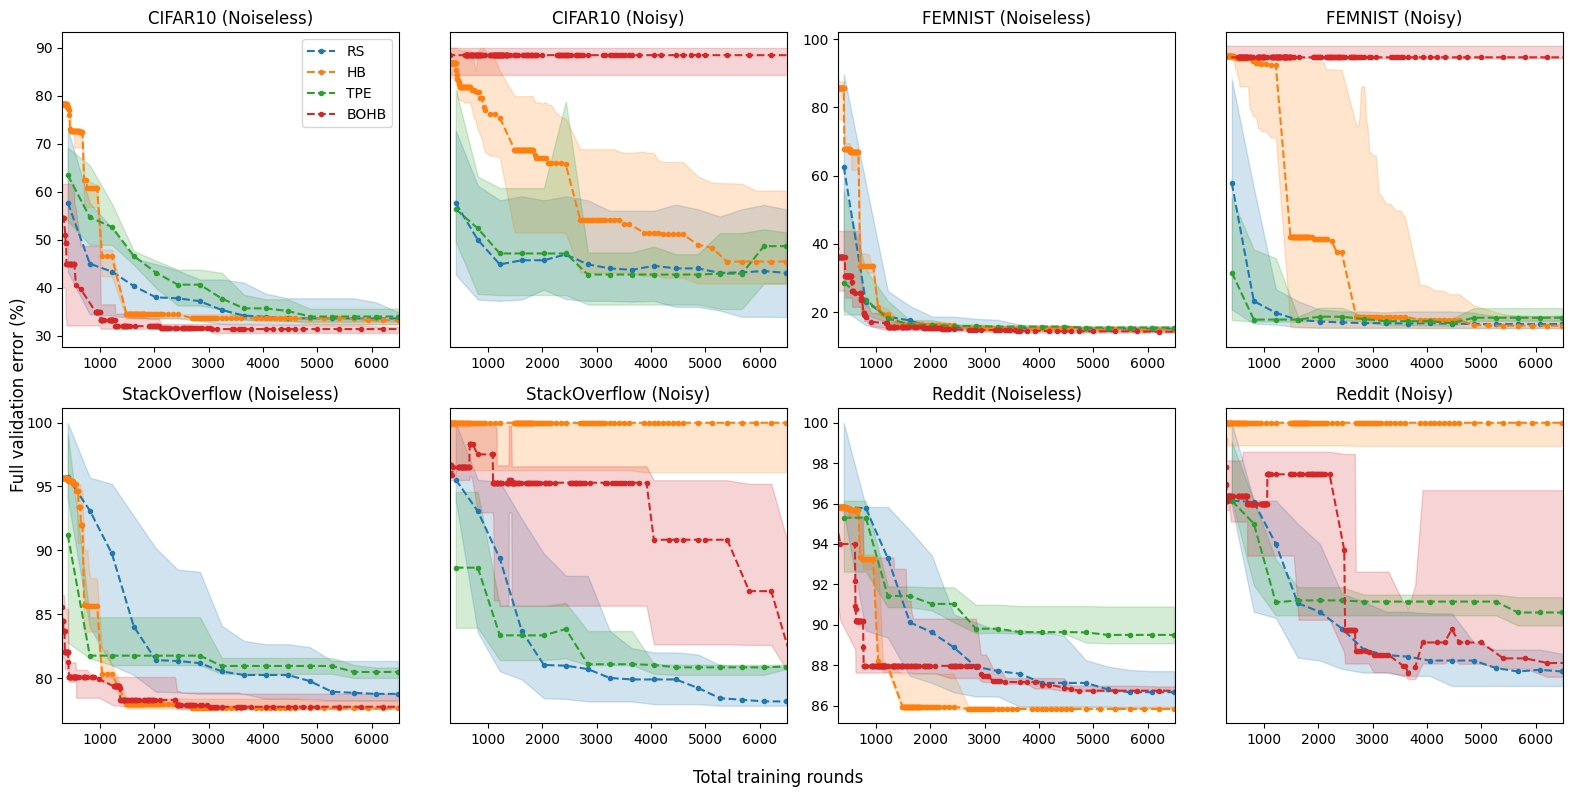

In [29]:
def plot_budget_trace(ax, X, traces, label, linestyle=None, color=None):
    md = 100*np.median(traces, axis=0)
    q1 = 100*np.quantile(traces, q=0.25, axis=0)
    q2 = 100*np.quantile(traces, q=0.75, axis=0)
    if color is None:
        ax.plot(X, md, label=f"{label}", linestyle=linestyle, marker='o', markersize=3)
        ax.fill_between(X, q1, q2, alpha=0.2)
    else:
        ax.plot(X, md, label=f"{label}", linestyle=linestyle, marker='o', markersize=3, color=color)
        ax.fill_between(X, q1, q2, alpha=0.2, color=color)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,4,figsize=(16,8))
data_p = 0
sys_bias = 0
for i, ds in enumerate(datasets):
    for j, suffix in enumerate(["", "_s_e=100"]):
        ax = axs[i//2][2*(i%2)+j]
        dp_eps = None if j == 0 else 100
        nc = NC_dict[ds][-1] if j == 0 else nc_dict[ds]
        # RS
        if (nc, data_p, dp_eps, sys_bias) in dp_rs_results[ds]:
            X = 405*np.arange(1,17)
            plot_budget_trace(
                ax=ax, X=X, 
                traces=[trial[1] for trial in dp_rs_results[ds][nc, data_p, dp_eps, sys_bias]], 
                label=f"RS",
                linestyle='dashed',
                color='tab:blue'
            )
        # HB
        X = [j*5 for j in hb_results[ds][nc, data_p, dp_eps, sys_bias][0][0]]
        plot_budget_trace(
            ax=ax, X=X, 
            traces=[trial[1] for trial in hb_results[ds][nc, data_p, dp_eps, sys_bias]], 
            label=f"HB",
            linestyle='dashed',
            color='tab:orange'
        )
        # TPE
        if ds+suffix in tpe_results:
            X = tpe_results[ds+suffix][0]
            plot_budget_trace(
                ax, X, 
                traces=tpe_results[ds+suffix][1][:6], 
                label=f"TPE", 
                linestyle='dashed',
                color='tab:green'
            )
        # BOHB
        if ds+suffix in bohb_results:
            X = bohb_results[ds+suffix][0]
            plot_budget_trace(
                ax, X, 
                traces=bohb_results[ds+suffix][1], 
                label=f"BOHB", 
                linestyle='dashed',
                color='tab:red'
            )

        if j == 1:
            ax.set_ylim(axs[i//2][2*(i%2)].get_ylim())
            ax.set_yticks([])
        settings = ["Noiseless", "Noisy"]
        ax.set_title(f"{ds} ({settings[j]})")
        ax.set_xlim(300, 6500)
        # else:
        #     ax.set_ylabel(cd)

axs[0][0].legend(loc='upper right')
# axs[0][2].legend(loc='upper right')
# axs[1][0].legend(loc='upper right')
# axs[1][1].legend(loc='upper right')
fig.supxlabel("Total training rounds")
fig.supylabel("Full validation error (%)")
plt.tight_layout()
plt.savefig('figures/HPO_BUDGET.pdf')
plt.show()

Figure 10: Proxy scatter plot

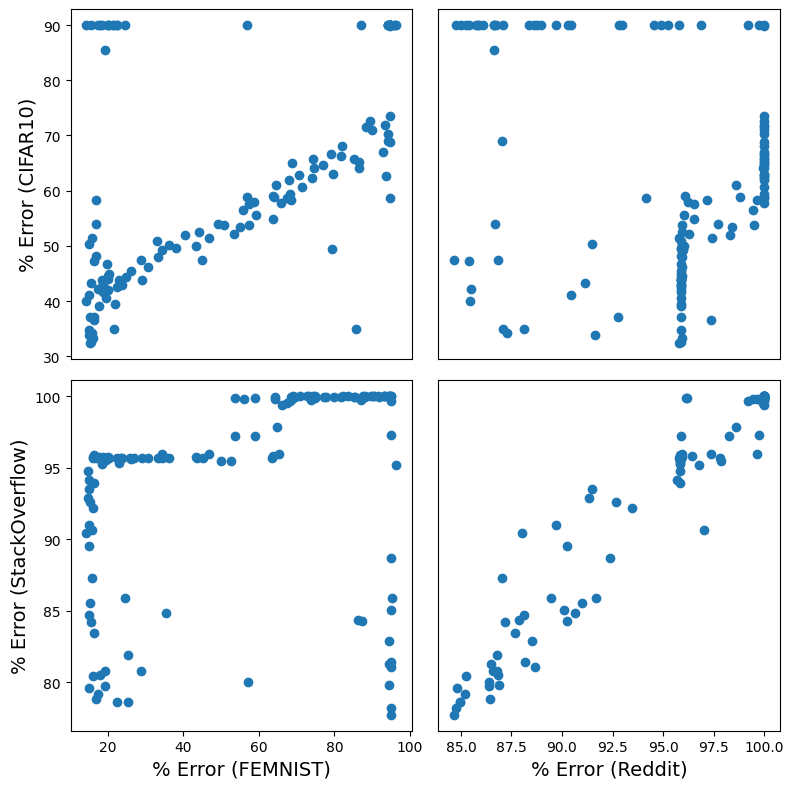

In [25]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
# fig, axs = plt.subplots(1,4,figsize=(16,4))
i = 0
for d2 in ['CIFAR10', 'StackOverflow']: # rows
    for d1 in ['FEMNIST', 'Reddit']: # cols
        y, x = i//2, i%2
        ax = axs[y][x]
        # ax = axs[i]
        if x == 1:
            ax.set_yticks([])
        if y == 0:
            ax.set_xticks([])
        if x == 0:
            ax.set_ylabel(f"Error rate ({get_title(d2)})", fontsize=14)
            ax.set_ylabel(f"% Error ({d2})")
        if y == 1:
            ax.set_xlabel(f"Error rate ({get_title(d1)})", fontsize=14)
            ax.set_xlabel(f"% Error ({d1})")
        nc1 = NC_dict[ds][-1]
        nc2 = NC_dict[d2][-1]

        min_d = d1 if len(eval_dicts[d1]) < len(eval_dicts[d1]) else d2
        runs = list(set(['-'.join(run.split('-')[1:]) for run, _, _ in eval_dicts[min_d].keys()]))[:127]
        x = np.array([(eval_dicts[d1][f"{d1.lower()}-{run}", 405, 0]*sizes[d1, 0]).sum() / sizes[d1, 0].sum() for run in runs])
        y = np.array([(eval_dicts[d2][f"{d2.lower()}-{run}", 405, 0]*sizes[d2, 0]).sum() / sizes[d2, 0].sum()  for run in runs])
        import matplotlib.pyplot as plt
        ax.scatter(100*x, 100*y)
        i+=1
plt.tight_layout()
# plt.savefig("figures/PX_SCATTER.pdf")
plt.show()

Figure 11: Proxy bar plot

/tmp/ipykernel_19762/3167980906.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(datasets, rotation=40, ha='right',va='top')


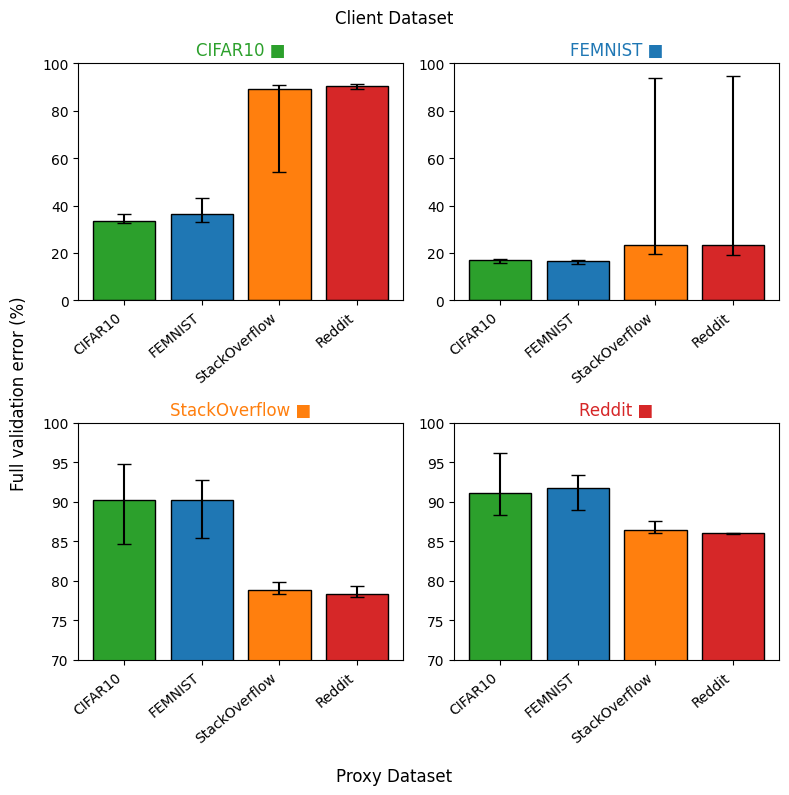

In [26]:
c = ["tab:green", "tab:blue", "tab:orange", "tab:red"]
fig, axs = plt.subplots(2,2,figsize=(8,8))
# fig, axs = plt.subplots(1,4,figsize=(16,4))
for i, ds in enumerate(datasets):
    ax = axs[i//2][i%2]
    # ax = axs[i]
    ax.set_ylim(0, 100)
    # rg = 100*np.median(np.array([(eval_dicts[ds][run, 405, 0]*sizes[ds,0]).sum() / sizes[ds,0].sum() for run in runs]))
    # ax.plot([-.25,3.25], [rg]*2, linestyle='dashed', label='Random HPs', color='red')
    # bc = 100*np.min(np.array([(eval_dicts[ds][run, 405, 0]*sizes[ds,0]).sum() / sizes[ds,0].sum() for run in runs]))
    # ax.plot([-.25,3.25], [bc]*2, linestyle='dashed', label='Best HPs', color='green')
    for j, pds in enumerate(datasets):
        true_errs = []
        for trial_results in rs_results[pds][NC_dict[pds][-1],0,None,0]:
            proxy_run_str = trial_results[3]
            seed = proxy_run_str.split('-')[2]
            if int(seed) > 127:
                continue
            true_err = eval_dicts[ds][f"{ds.lower()}-{'-'.join(proxy_run_str.split('-')[1:])}", 405, 0].sum() / NC_dict[ds][-1]
            true_errs.append(true_err)
        md = 100*np.median(true_errs)
        q1 = 100*np.quantile(true_errs, q=0.25)
        q2 = 100*np.quantile(true_errs, q=0.75)
        ax.bar(j, md, yerr=[
            [md-q1],
            [q2-md]
        ], capsize=5, edgecolor='k', color=c[j])
    ax.set_xticklabels(datasets, rotation=40, ha='right',va='top')
    ax.set_xticks([0,1,2,3])
    if i == 0:
        pass
    if i == 1:
        pass
    if i == 2:
        ax.set_ylim(70, 100)
    if i == 3:
        ax.set_ylim(70, 100)
        # ax.set_yticks([])
    ax.set_title(f"{ds} \u25A0", color=c[i])

    # if i == 2 or i == 3:
    #     d = .5  # proportion of vertical to horizontal extent of the slanted line
    #     kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
    #                 linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    #     ax.plot([0], [0], transform=ax.transAxes, **kwargs)
    #     ax.plot([0], [0.01], transform=ax.transAxes, **kwargs)
fig.supylabel('Full validation error (%)')
fig.supxlabel('Proxy Dataset')
fig.suptitle('Client Dataset')
plt.tight_layout()
plt.savefig("figures/PX_BAR.pdf")

Figure 12: Proxy vs. Noisy Eval

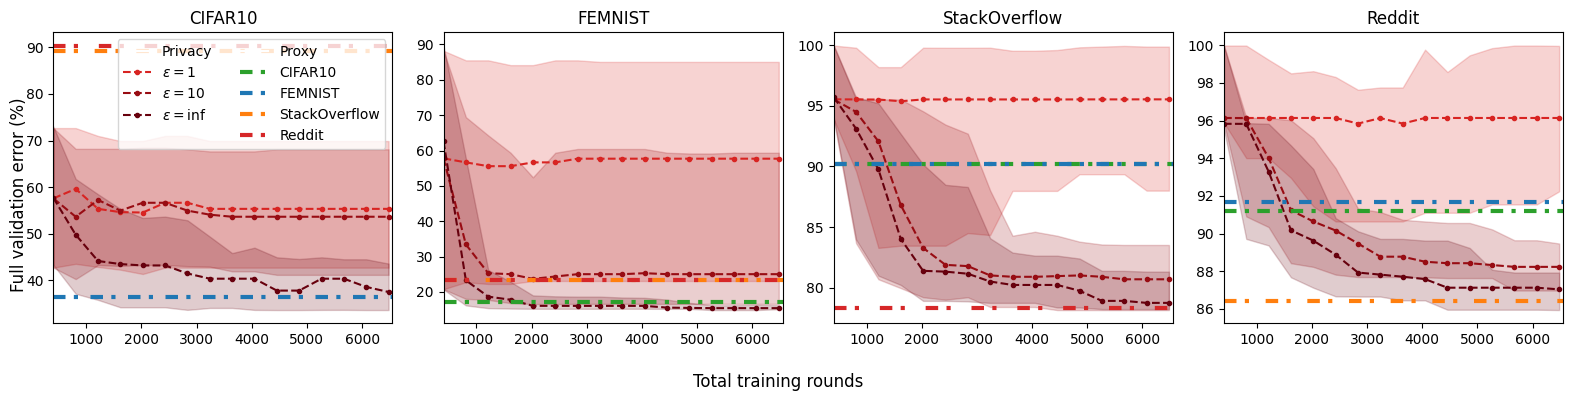

In [28]:
def plot_subsampling_trace(ax, results, dataset, N, data_p=0, dp_eps=None, sys_bias=0, label='', color='k'):
    ncs = NC_dict_pow[dataset]
    md = [100*np.median(  np.array([trial[1][N-1] for trial in results[nc,data_p,dp_eps,sys_bias]]), axis=0) for nc in ncs]
    q1 = [100*np.quantile(np.array([trial[1][N-1] for trial in results[nc,data_p,dp_eps,sys_bias]]), q=0.25, axis=0) for nc in ncs]
    q2 = [100*np.quantile(np.array([trial[1][N-1] for trial in results[nc,data_p,dp_eps,sys_bias]]), q=0.75, axis=0) for nc in ncs]
    ax.plot(ncs, md, label=label, marker='o', linestyle='dashed', color=color)
    ax.fill_between(ncs, q1, q2, alpha=0.1, color=color)

c = plt.get_cmap("Reds")
import matplotlib.pyplot as plt
budgets = 405*np.arange(1,17)
fig, axs = plt.subplots(1,4,figsize=(16,4))

sys_bias = 0
data_p = 0
for i, ds in enumerate(datasets):
    ax = axs[i]
    # Noisy Eval
    dpc = {
        1: c(180),
        10: c(230),
        None: c(280)
    }
    ax.plot([], [],color='w',label=f"Privacy")
    for dp_eps in [1,10,None]:
        plot_budget_trace(ax, budgets, [trial[1] for trial in dp_rs_results[ds][nc_dict[ds], data_p, dp_eps, sys_bias][:]], 
                        #   label=f"{ds} $(\sim 1\%$ clients, $\epsilon={dp_eps if dp_eps is not None else 'inf'})$",
                          label=f"$\epsilon=${dp_eps if dp_eps is not None else 'inf'}",
                          color=dpc[dp_eps],
                          linestyle='dashed')
    
    # Proxies
    ax.plot([], [],color='w',label=f" ")
    ax.plot([], [],color='w',label=f"Proxy")
    pc = ['tab:green', 'tab:blue', 'tab:orange', 'tab:red']
    ls = [(0,(3,2,1,2)), (0,(3,2,1,3)), (0,(3,2,1,4)), (0,(3,2,1,5))]
    for j, pds in enumerate(datasets):
        if ds == pds:
            ax.plot([], [] ,color=pc[j], label=f"{pds}", linestyle=ls[j], linewidth=3)
            continue
        true_errs = []
        for trial_results in rs_results[pds][NC_dict[pds][-1],0,None,0]:
            proxy_run_str = '-'.join(trial_results[3].split('-')[1:])
            config = (f"{ds.lower()}-{proxy_run_str}", 405, 0)
            if int(proxy_run_str.split('-')[1]) < 128:
                true_err = eval_dicts[ds][config].sum() / NC_dict[ds][-1]
                true_errs.append(true_err)
        m = 100*np.median(true_errs)
        q1 = 100*np.quantile(true_errs, q=0.25)
        q2 = 100*np.quantile(true_errs, q=0.75)
        ax.plot([405,6550], [m]*2,color=pc[j], label=f"{pds}", linestyle=ls[j], linewidth=3)
        # ax.fill_between([405, 6550], [q1]*2, [q2]*2, color=pc[j], alpha=0.2)
        ax.set_xlim(405, 6550)

    ax.set_title(ds)
    
    if i == 0:
        ax.legend(loc='best', ncol=2)

# axs[0][0].legend(title='Fraction of eval clients', loc='upper right')
fig.supxlabel("Total training rounds")
fig.supylabel("Full validation error (%)")
plt.tight_layout()
plt.savefig('figures/PX_BUDGET.pdf')
plt.show()

Stacked Bar Plots

/tmp/ipykernel_19762/3340381586.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0f}" for x in ax.get_yticks()*100])


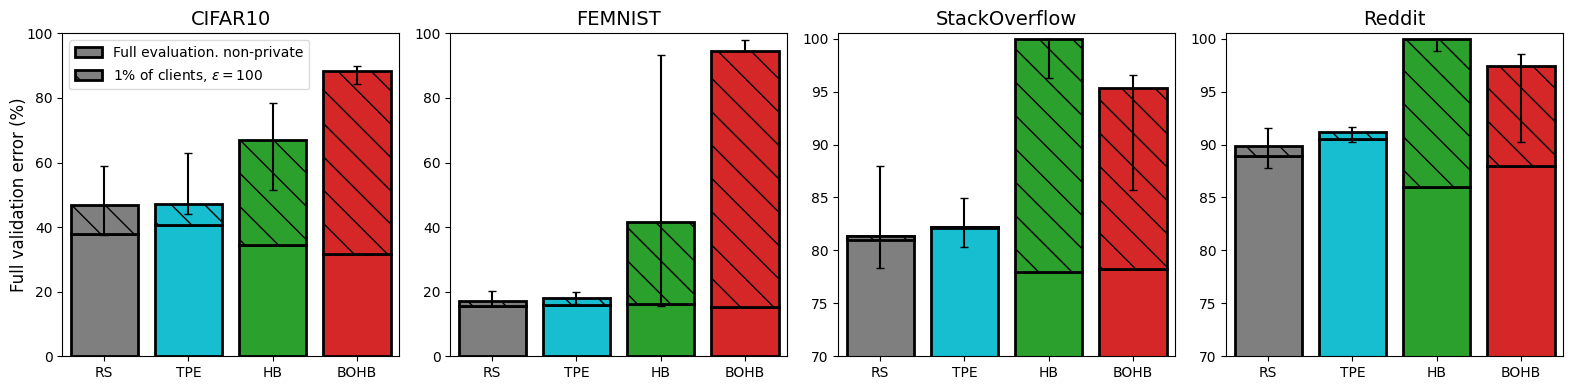

In [33]:
# dataset: CIFAR10
# one group of bars for each setting
    # one bar for each HPO method
# 6480 rounds
# hb_idx = -1
# bohb_idx = -2
# rs_idx = -1
# filename = "figures/HPO_BAR_MAX.pdf"
# 2000 rounds
hb_idx = -46
bohb_idx = -43
rs_idx = 5
filename = "figures/HPO_BAR_2K.pdf"
c = ['tab:gray', 'tab:cyan', 'tab:green' ,'tab:red']
fig, axs = plt.subplots(1, 4, figsize=(16,4))
# for i, ds in enumerate(['CIFAR10']):
for i, ds in enumerate(datasets):
    ax = axs[i]
    j = i*1.25
    nc = nc_dict[ds]
    for setting in ['full', 'dp']:
        if setting == 'full':
            full = {
                'rs': np.median([trial[1][rs_idx] for trial in dp_rs_results[ds][NC_dict[ds][-1], 0, None, 0]]),
                'tpe': np.median([trial[rs_idx] for trial in tpe_results[ds][1]]),
                'hb': np.median([trial[1][hb_idx] for trial in hb_results[ds][NC_dict[ds][-1], 0, None, 0]]),
                'bohb': np.median([trial[bohb_idx] for trial in bohb_results[ds][1]])
            }
            for z, k in enumerate(full):
                ax.bar(0.5*z, full[k], width=0.4, color=c[z], edgecolor='k', linewidth=2, label='' if z > 0 else 'Full evaluation. non-private')

        # if setting == 'sub':
        #     dp_eps = None
        #     sub = {
        #         'rs': np.median([trial[1][rs_idx] for trial in rs_results[ds][nc, 0, dp_eps, 0]]),
        #         'tpe': np.median([trial[rs_idx] for trial in tpe_results[ds +"_s"][1]]),
        #         'hb': np.median([trial[1][hb_idx] for trial in hb_results[ds][nc, 0, dp_eps, 0]]),
        #         'bohb': np.median([trial[bohb_idx] for trial in bohb_results[ds + "_s"][1]])
        #     }
        #     ax.bar(0, sub['rs'] - full['rs'], bottom=full['rs'], width=0.4, color=c[0], hatch='/', edgecolor='k', linewidth=2, label='1% of clients')
        #     ax.bar(0.5, sub['tpe'] - full['tpe'], bottom=full['tpe'], width=0.4, color=c[1], hatch='/', edgecolor='k', linewidth=2)
        #     ax.bar(1.0, sub['hb'] - full['hb'], bottom=full['hb'], width=0.4 , color=c[2], hatch='/', edgecolor='k', linewidth=2)
        #     ax.bar(1.5, sub['bohb'] - full['bohb'], bottom=full['bohb'], width=0.4, color=c[3], hatch='/', edgecolor='k', linewidth=2)
        
        if setting == 'dp':
            dp_eps = 100
            dp = {
                'rs': [trial[1][rs_idx] for trial in dp_rs_results[ds][nc, 0, dp_eps, 0]],
                'tpe': [trial[rs_idx] for trial in tpe_results[ds+f"_s_e={dp_eps}"][1]],
                'hb': [trial[1][hb_idx] for trial in hb_results[ds][nc, 0, dp_eps, 0]],
                'bohb': [trial[bohb_idx] for trial in bohb_results[ds+f"_s_e={dp_eps}"][1]]
            }
            for z, (k, v) in enumerate(dp.items()):
                m = np.median(v)
                q1 = np.quantile(v, q=0.25)
                q2 = np.quantile(v, q=0.75)
                # ax.bar(j*0.5, m - sub[k], yerr=[[m - q1],[q2-m]], bottom=sub[k], width=0.4, 
                ax.bar(z*0.5, m - full[k], yerr=[[m - q1],[q2-m]], bottom=full[k], width=0.4, 
                color=c[z], edgecolor='k', hatch='\\', linewidth=2, label='$1\%$ of clients, $\epsilon=100$' if z == 0 else None,
                capsize=3)
        
        hps = ['RS', 'TPE', 'HB', 'BOHB']
        if i == 0:
            ax.legend(loc='upper left', framealpha=0.7)
            ax.set_ylim(0, 1)
            ax.set_xticks([0, 0.5, 1.0, 1.5], hps)
        if i == 1:
            ax.set_ylim(0, 1)
            # ax.set_yticks([])
            ax.set_xticks([0, 0.5, 1.0, 1.5], hps)
        if i == 2:
            ax.set_ylim(0.7, 1.005)
            ax.set_xticks([0, 0.5, 1.0, 1.5], hps)
        if i == 3:
            ax.set_ylim(0.7, 1.005)
            # ax.set_yticks([])
            ax.set_xticks([0, 0.5, 1.0, 1.5], hps)
        ax.set_title(ds, fontsize=14)
        ax.set_xlim(-0.25, 1.75)
        ax.set_yticklabels([f"{x:.0f}" for x in ax.get_yticks()*100])
        # ax.legend()
fig.supylabel("Full validation error (%)")
# fig.supxlabel("HPO Algorithm")
plt.tight_layout()
plt.savefig(filename)

0.4289266014099121 0.36281771659851075 0.5641113662719727


/tmp/ipykernel_19762/33772764.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x:.0f}" for x in ax.get_yticks()*100])


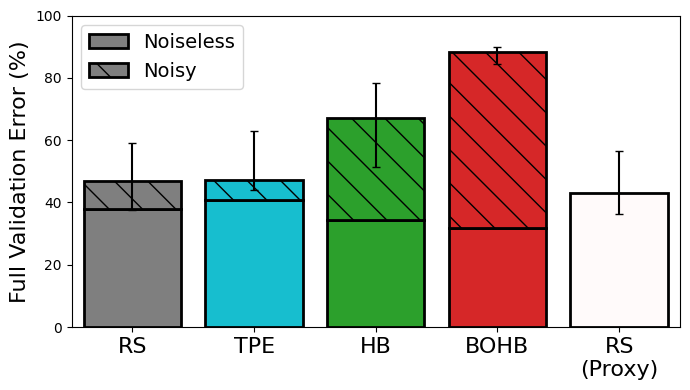

In [34]:
c = ['tab:gray', 'tab:cyan', 'tab:green' ,'tab:red']
ds = "CIFAR10"
# 6480 rounds
# hb_idx = -1
# bohb_idx = -2
# rs_idx = -1
# 2000 rounds
hb_idx = -46
bohb_idx = -43
rs_idx = 5
nc = nc_dict[ds]
fig, ax = plt.subplots(1,1,figsize=(7,4))

# proxy
pds = "FEMNIST"
def get_pd_err(ds, pds):
    proxy_errs = []
    true_errs = []
    for trial_results in rs_results[pds][NC_dict[pds][-1],0,None,0]:
        proxy_run_str = '-'.join(trial_results[3].split('-')[1:])
        proxy_err = trial_results[1][-1]
        true_err = eval_dicts[ds][f"{ds.lower()}-{proxy_run_str}", 405, 0].sum() / NC_dict[ds][-1]
        true_errs.append(true_err)
        proxy_errs.append(proxy_err)
    # combine k=16 -> 32 for slightly larger proxy search
    # comb_true_errs = []
    # for i in range(0, len(true_errs), 2):
    #     if proxy_errs[i] < proxy_errs[i+1]:
    #         comb_true_errs.append(true_errs[i])
    #     else:
    #         comb_true_errs.append(true_errs[i+1])
    # return comb_true_errs
    return true_errs

true_errs = get_pd_err(ds,pds)
m = np.median(true_errs)
q1 = np.quantile(true_errs, q=0.25)
q2 = np.quantile(true_errs, q=0.75)
print(m, q1, q2)
ax.bar(2, m, width=0.4, 
    color='snow', edgecolor='k', linewidth=2,
    yerr=[[m - q1],[q2-m]],
    capsize=3)

for setting in ['full', 'dp']:
    if setting == 'full':
        full = {
            'rs': np.median([trial[1][rs_idx] for trial in dp_rs_results[ds][NC_dict[ds][-1], 0, None, 0]]),
            'tpe': np.median([trial[rs_idx] for trial in tpe_results[ds][1]]),
            'hb': np.median([trial[1][hb_idx] for trial in hb_results[ds][NC_dict[ds][-1], 0, None, 0]]),
            'bohb': np.median([trial[bohb_idx] for trial in bohb_results[ds][1]])
        }
        for z, k in enumerate(full):
            ax.bar(0.5*z, full[k], width=0.4, color=c[z], edgecolor='k', linewidth=2, label='' if z > 0 else 'Noiseless')

    if setting == 'dp':
        dp_eps = 100
        dp = {
            'rs': [trial[1][rs_idx] for trial in dp_rs_results[ds][nc, 0, dp_eps, 0]],
            'tpe': [trial[rs_idx] for trial in tpe_results[ds+f"_s_e=100"][1]],
            'hb': [trial[1][hb_idx] for trial in hb_results[ds][nc, 0, dp_eps, 0]],
            'bohb': [trial[bohb_idx] for trial in bohb_results[ds+f"_s_e=100"][1]]
        }
        for z, (k, v) in enumerate(dp.items()):
            m = np.median(v)
            q1 = np.quantile(v, q=0.25)
            q2 = np.quantile(v, q=0.75)
            # ax.bar(j*0.5, m - sub[k], yerr=[[m - q1],[q2-m]], bottom=sub[k], width=0.4, 
            ax.bar(z*0.5, m - full[k], yerr=[[m - q1],[q2-m]], bottom=full[k], width=0.4, 
            color=c[z], edgecolor='k', hatch='\\', linewidth=2, label="Noisy" if z == 0 else None,
            capsize=3)
    
    hps = ['RS', 'TPE', 'HB', 'BOHB', 'RS\n(Proxy)']
    ax.legend(loc='upper left', fontsize=14)# framealpha=0.7, )
    ax.set_ylim(0, 1)
    ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0], hps, fontsize=16)
    # ax.set_title(ds, fontsize=14)
    ax.set_xlim(-0.25, 2.25)
    # ax.set_ylim(0, 0.3)
    ax.set_yticklabels([f"{x:.0f}" for x in ax.get_yticks()*100])
    # ax.legend()
    ax.set_ylabel("Full Validation Error (%)", fontsize=16)
plt.tight_layout()
plt.savefig('figures/HPO_CIFAR.pdf')
plt.show()

Figure 13: HPO Space

In [263]:
cutoffs = [(10**-4.5, 10**-3.5), (10**-5, 10**-3), (10**-5.5, 10**-2.5), (10**-6, 10**-2)]
def bin_runs(runs):
    lrs = [float(run.split('-momentum')[0].split('-lr_')[1]) for run in runs]
    bins = [[] for c in cutoffs]
    for i in range(len(runs)):
        for j in range(len(cutoffs)):
            if lrs[i] > cutoffs[j][0] and lrs[i] < cutoffs[j][1]:
                bins[j].append(runs[i])
    return bins

In [278]:
trials = 40
bins_rs_results = [{ds: {} for ds in datasets} for c in cutoffs]
for ds, eval_dict in list(eval_dicts.items()):
    all_runs = list(set(run for run, _, _ in eval_dict.keys()))
    bins = bin_runs(all_runs)
    for i, runs in enumerate(bins):
        N = len(runs)
        trials_runs = [np.random.choice(runs, N, replace=False) for trial in range(trials)]
        NUM_CLIENTS = NC_dict[ds]
        sub_nc = nc_dict[ds]
        cfg_results = {}
        configs = []
        for nc in [1, NUM_CLIENTS[-1]]:
            dp_eps=10
            configs.append((nc, 0, dp_eps, 0))

        for config in configs:
            cfg_results[config] = []
            nc, data_p, dp_eps, sys_bias = config
            for trial in range(trials):
                client_sizes = sizes[ds,data_p]
                trial_runs = trials_runs[trial]
                cfg_results[config].append(run_rs(
                    client_sizes, trial_runs, eval_dict, nc=nc, N=N, NC=NUM_CLIENTS[-1], R=405, 
                    data_p=data_p, dp_eps=dp_eps, sys_bias=sys_bias))
        bins_rs_results[i][ds] = cfg_results

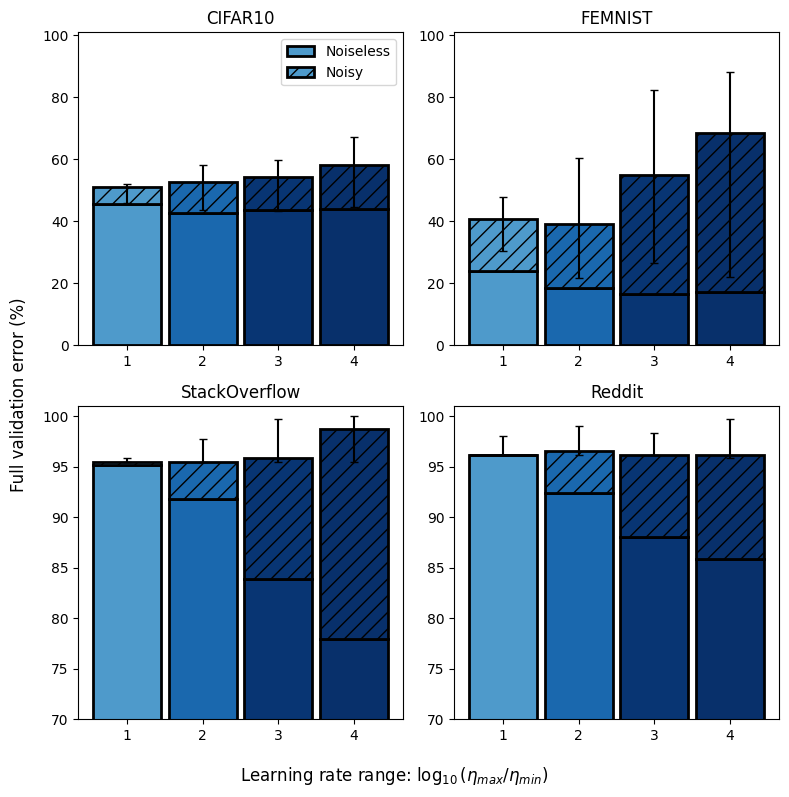

In [331]:
c = plt.get_cmap('Blues')
# fig, axs = plt.subplots(1,4,figsize=(16,4))
fig, axs = plt.subplots(2,2,figsize=(8,8))
# Use eps=10
colors = [c(150), c(200), c(250), c(300)]
rs_idx = -1
for i, ds in enumerate(datasets):
    ax = axs[i//2][i%2]
    for j, bin_rs_results in enumerate(bins_rs_results):
        m = 100*np.median([trial[1][rs_idx] for trial in bin_rs_results[ds][NC_dict[ds][-1], 0, 10, 0]])
        q1 = 100*np.quantile([trial[1][rs_idx] for trial in bin_rs_results[ds][NC_dict[ds][-1], 0, 10, 0]], q=0.25)
        q2 = 100*np.quantile([trial[1][rs_idx] for trial in bin_rs_results[ds][NC_dict[ds][-1], 0, 10, 0]], q=0.75)
        ax.bar(j, m, color=colors[j], edgecolor='k', linewidth=2, width=0.9, label='Noiseless') #, yerr=[[m - q1],[q2-m]])
        m2 = 100*np.median([trial[1][rs_idx] for trial in bin_rs_results[ds][1, 0, 10, 0]])
        q1 = 100*np.quantile([trial[1][rs_idx] for trial in bin_rs_results[ds][1, 0, 10, 0]], q=0.25)
        q2 = 100*np.quantile([trial[1][rs_idx] for trial in bin_rs_results[ds][1, 0, 10, 0]], q=0.75)
        ax.bar(j, m2-m, bottom=m, hatch='//', color=colors[j], edgecolor='k', yerr=[[m2 - q1],[q2-m2]], capsize=3, linewidth=2, width=0.9, label='Noisy')
    
    if i == 0:
        ax.set_ylim(0, 101)
        ax.legend(labels=["Noiseless", "Noisy"])
    if i == 1:
        ax.set_ylim(0, 101)
    if i == 2:
        ax.set_ylim(70, 101)
    if i == 3:
        ax.set_ylim(70, 101)
        
    ax.set_title(ds)
    ax.set_xticks([0,1,2,3], [1,2,3,4])
fig.supxlabel('Learning rate range: $\log_{10}(\eta_{max} / \eta_{min})$')
fig.supylabel('Full validation error (%)')
fig.tight_layout()
fig.show()
fig.savefig('figures/HPO_SPACE.pdf')